In [1]:
import numpy as np
import pandas as pd
import gc
from tqdm import *
import os
import copy
import sys
import time
from collections import Counter, deque
from multiprocessing import Pool, cpu_count

import transforms3d

from sklearn.manifold import TSNE, LocallyLinearEmbedding
from sklearn.cluster import MeanShift

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import ipyvolume as ipv
import open3d as o3d

import warnings
warnings.filterwarnings("ignore")

# %matplotlib inline
# %matplotlib notebook

In [2]:
# ATM_PATH = "/Users/saby/Projects/atm/"
ATM_PATH = "/home/nilesh/Prashant/sabyasachi/atm"
DATA_PATH = os.path.join(ATM_PATH, "data", "data", "datasets")

IISC_DATA_PATH = os.path.join(DATA_PATH, "IISC")
# EXP_PATH = os.path.join(IISC_DATA_PATH, "2019-02-26","ref_run_ccw_r")
EXP_PATH = os.path.join(IISC_DATA_PATH, "2019-03-30","15-41-43-mule1-auto-slam2d_test_track_ccw_5loops")

LIDAR_PCD_PATH = os.path.join(EXP_PATH, "complete")
LIDAR_CSV_PATH = os.path.join(IISC_DATA_PATH, "lidar.csv")

In [3]:
VOXEL_SZ = 0.2

def pose2matrix(translation_list, rotation_angle_list):
    trans_vec = np.array(translation_list)
    rot_ang = [np.deg2rad(ang) for ang in rotation_angle_list ]
    rot_mat = transforms3d.euler.euler2mat(rot_ang[0], rot_ang[1], rot_ang[2])
    zoom = np.ones(3)
    transform_mat = transforms3d.affines.compose(trans_vec, rot_mat, zoom)
    return transform_mat

def filter_pcd(old_pcd,
               apply_downsample = True,
               downsample_voxel_size = VOXEL_SZ,
               
               apply_outlier_removal = True,
               downsample_radius = 1,
               downsample_neighbors = 20,
               
               apply_crop = True,
               crop_min_arr = np.array([-100,-100,0]),
               crop_max_arr = np.array([100,100,100]),
               
               apply_cluster = True,
               cluster_neighbours = 30,
               cluster_labels = 2):
    np.random.seed(0)
    pcd = copy.deepcopy(old_pcd)
    
    if apply_downsample:
        voxel_down_pcd = o3d.geometry.voxel_down_sample(pcd, voxel_size = downsample_voxel_size)
        pcd = voxel_down_pcd

    if apply_outlier_removal:
        denser_pcd, ind = o3d.geometry.radius_outlier_removal(pcd,
                                                              nb_points = downsample_neighbors,
                                                              radius    = downsample_radius)
        pcd = denser_pcd
    
    if apply_crop:
        cropped_pcd = o3d.geometry.crop_point_cloud(pcd, crop_min_arr, crop_max_arr)
        pcd = cropped_pcd

    if apply_cluster:
        few_pts = np.asarray(pcd.points)
        try:
            few_pts_reduced = LocallyLinearEmbedding(n_neighbors=cluster_neighbours, n_components=2).fit_transform(few_pts)
        except Exception as e:
            try:
                few_pts_reduced = LocallyLinearEmbedding(n_neighbors=cluster_neighbours, n_components=2, eigen_solver='dense').fit_transform(few_pts)
            except Exception as e:
                few_pts_reduced = few_pts
        clf = MeanShift().fit(few_pts_reduced)
        pcd.points = o3d.utility.Vector3dVector(few_pts[clf.labels_ < cluster_labels])
    
    return pcd

def read_pcd(pcd_id):
    pcd_file = str(pcd_id) + ".pcd"
    pcd = o3d.io.read_point_cloud(os.path.join(LIDAR_PCD_PATH, pcd_file))
    return pcd

def draw_pcd(pcd, where='mat_3d'):
    if where is 'opn_nb':
        visualizer = o3d.JVisualizer()
        visualizer.add_geometry(pcd)
        visualizer.show()
    elif where is 'opn_view':
        o3d.visualization.draw_geometries([pcd], width=1280, height=800)
    elif where is 'mat_3d':
        plt.figure()
        pts = np.asarray(pcd.points)
        plt.scatter(pts[:,0], pts[:,1], pts[:,2])
        plt.grid()
        plt.show()
    elif where is 'mat_2d':
        plt.figure()
        pts = np.asarray(pcd.points)
        plt.scatter(pts[:,0], pts[:,1])
        plt.grid()
        plt.show()
        
def draw_registration_result(src_pcd, dst_pcd, x_pt, y_pt, theta):    
    src_pcd_tmp = copy.deepcopy(src_pcd)
    dst_pcd_tmp = copy.deepcopy(dst_pcd)
    
    src_pcd_tmp.paint_uniform_color([1, 0, 0])  # red source
    dst_pcd_tmp.paint_uniform_color([0, 0, 1])  # blue target
    
    transform_mat = pose2matrix([x_pt, y_pt, 0], [0,0,theta])
    dst_pcd_tmp.transform(transform_mat)
    
    visualizer = o3d.JVisualizer()
    visualizer.add_geometry(src_pcd_tmp)
    visualizer.add_geometry(dst_pcd_tmp)
    visualizer.show()

In [4]:
df_carto = pd.read_csv(os.path.join(EXP_PATH, 'offline_carto', 'local_pose.csv'))

In [5]:
df_carto.shape

(4697, 9)

In [6]:
df_carto.head()

,timestamp,x,y,z,qw,qx,qy,qz,yaw
0,9530.9300,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
1,9531.0315,0.0000,0.0000,0.0000,0.9994,-0.0169,-0.0297,0.0000,0.0010
2,9531.1323,-0.0042,0.0009,-0.0114,0.9994,-0.0169,-0.0296,0.0000,0.0010
3,9531.2319,0.0017,0.0024,-0.0100,0.9994,-0.0170,-0.0295,0.0001,0.0011
4,9531.3314,-0.0015,0.0002,-0.0125,0.9994,-0.0171,-0.0294,0.0001,0.0012


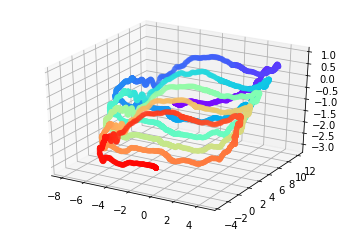

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_carto['x'].values, df_carto['y'].values, df_carto['z'].values, c=cm.rainbow(np.array(range(df_carto.shape[0]))/df_carto.shape[0]))

In [8]:
pose_pcd = o3d.PointCloud()
pose_pts = np.array([(row['x'], row['y'], row['z']) for idx, row in df_carto.iterrows() ])
pose_clr = cm.rainbow(np.array(range(df_carto.shape[0]))/df_carto.shape[0])[:,:3]
pose_pcd.points = o3d.utility.Vector3dVector(pose_pts)
pose_pcd.colors = o3d.utility.Vector3dVector(pose_clr)

In [9]:
draw_pcd(pose_pcd, where='opn_nb')

JVisualizer with 1 geometries

In [20]:
%matplotlib notebook

<IPython.core.display.Javascript object>


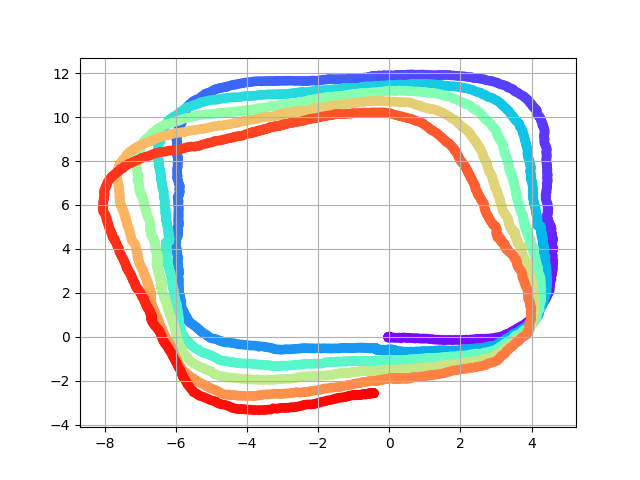

In [21]:
plt.figure()
plt.grid()
plt.scatter(df_carto['x'].values, df_carto['y'].values, c=cm.rainbow(np.array(range(df_carto.shape[0]))/df_carto.shape[0]))

<IPython.core.display.Javascript object>


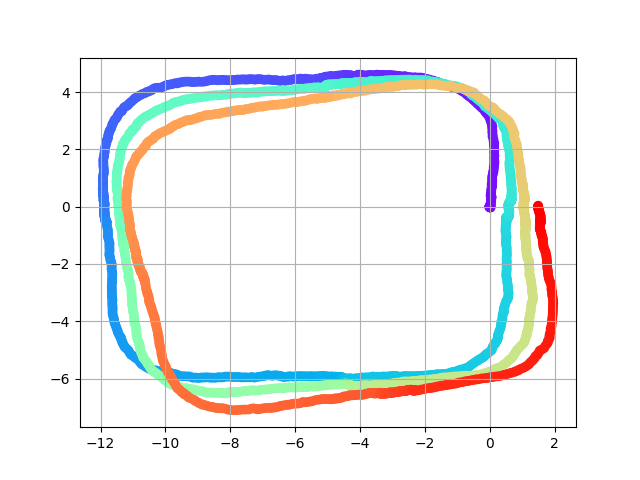

In [22]:
plt.figure()
n_poses = 3000
plt.grid()
plt.scatter(df_carto[:n_poses]['y'].values*-1, df_carto[:n_poses]['x'].values, c=cm.rainbow(np.array(range(n_poses))/n_poses))

<IPython.core.display.Javascript object>


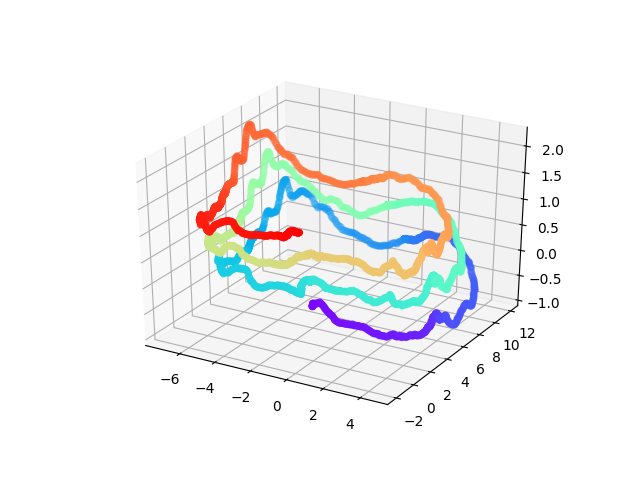

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_carto[:n_poses]['x'].values, df_carto[:n_poses]['y'].values, df_carto[:n_poses]['z'].values*-1, c=cm.rainbow(np.array(range(n_poses))/n_poses))

In [17]:
sample_pose_pcd = o3d.PointCloud()
sample_pose_pts = np.array([(row['x'], row['y'], row['z']) for idx, row in df_carto[:n_poses].iterrows() ])
sample_pose_clr = cm.rainbow(np.array(range(n_poses))/n_poses)[:,:3]
sample_pose_pcd.points = o3d.utility.Vector3dVector(sample_pose_pts)
sample_pose_pcd.colors = o3d.utility.Vector3dVector(sample_pose_clr)

In [18]:
draw_pcd(sample_pose_pcd, where='opn_nb')

JVisualizer with 1 geometries